In [10]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, Flatten, Dense, BatchNormalization, Activation, add
import tensorflow as tf
import keras.backend as K
from sklearn.metrics import explained_variance_score, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# make sure TF does not allocate all memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

In [3]:
data = np.load('simple_600K_disc0.99_cleaned.npz')
x_train = data['observations']
p_train = data['actions']
v_train = data['rewards']
x_train.shape, p_train.shape, v_train.shape

((594333, 11, 11, 18), (594333,), (594333,))

In [4]:
data = np.load('valid_100K_disc0.99_cleaned.npz')
x_test = data['observations']
p_test = data['actions']
v_test = data['rewards']
x_test.shape, p_test.shape, v_test.shape

((95623, 11, 11, 18), (95623,), (95623,))

In [12]:
def ConvBlock(mod):
    mod = Conv2D(filters=256, kernel_size=3, strides=1, padding="same")(mod)
    mod = BatchNormalization()(mod)
    mod = Activation('relu')(mod)
    return mod

def ResidualBlock(mod):
    tmp = mod
    mod = ConvBlock(mod)
    mod = Conv2D(filters=256, kernel_size=3, strides=1, padding="same")(mod)
    mod = BatchNormalization()(mod)
    mod = add([mod,tmp])
    mod = Activation('relu')(mod)
    return mod

def PolicyHead(mod):
    mod = Conv2D(filters=2, kernel_size=1, strides=1, padding="same")(mod)
    mod = BatchNormalization()(mod)
    mod = Activation('relu')(mod)
    mod = Flatten()(mod)
    mod = Dense(6, activation='softmax', name='p')(mod)
    return mod

def ValueHead(mod):
    mod = Conv2D(filters=1, kernel_size=1, strides=1, padding="same")(mod)
    mod = BatchNormalization()(mod)
    mod = Activation('relu')(mod)
    mod = Flatten()(mod)
    mod = Dense(256)(mod)
    mod = Activation('relu')(mod)
    mod = Dense(1)(mod)
    mod = Activation('tanh',name='v')(mod)
    return mod

h = x = Input(shape=(11,11,18))
h = ConvBlock(h)
for i in range(3):
    h = ResidualBlock(h)
p = PolicyHead(h)
v = ValueHead(h)
model = Model(x, [p, v])
model.summary()
model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'mse'], loss_weights=[1, 10], metrics={'p': 'accuracy'})

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 11, 11, 18)   0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 11, 11, 256)  41728       input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 11, 11, 256)  1024        conv2d_14[0][0]                  
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 11, 11, 256)  0           batch_normalization_13[0][0]     
__________________________________________________________________________________________________
conv2d_15 

In [13]:
history = model.fit(x_train, [p_train, v_train], batch_size=128, epochs=10, validation_data=(x_test, [p_test, v_test]))

Train on 594333 samples, validate on 95623 samples
Epoch 1/10
594333/594333 [==============================] - 1263s 2ms/step - loss: 2.6285 - p_loss: 1.3796 - v_loss: 0.1249 - p_acc: 0.4511 - val_loss: 2.7722 - val_p_loss: 0.8412 - val_v_loss: 0.1931 - val_p_acc: 0.6122
Epoch 2/10
594333/594333 [==============================] - 1259s 2ms/step - loss: 1.4321 - p_loss: 0.7752 - v_loss: 0.0657 - p_acc: 0.6346 - val_loss: 2.8289 - val_p_loss: 0.7384 - val_v_loss: 0.2090 - val_p_acc: 0.6484
Epoch 3/10
594333/594333 [==============================] - 1261s 2ms/step - loss: 1.1408 - p_loss: 0.7070 - v_loss: 0.0434 - p_acc: 0.6562 - val_loss: 2.8035 - val_p_loss: 0.7012 - val_v_loss: 0.2102 - val_p_acc: 0.6604
Epoch 4/10
594333/594333 [==============================] - 1263s 2ms/step - loss: 0.9821 - p_loss: 0.6719 - v_loss: 0.0310 - p_acc: 0.6694 - val_loss: 2.7501 - val_p_loss: 0.6809 - val_v_loss: 0.2069 - val_p_acc: 0.6660
Epoch 5/10
594333/594333 [==============================] - 1271s

Text(0.5,1,'Value MSE')

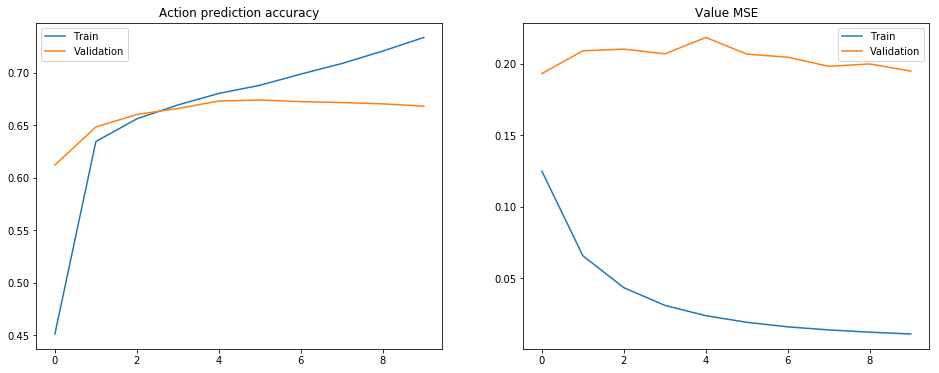

In [14]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['p_acc'])
plt.plot(history.history['val_p_acc'])
plt.legend(['Train', 'Validation'])
plt.title("Action prediction accuracy")
plt.subplot(1, 2, 2)
plt.plot(history.history['v_loss'])
plt.plot(history.history['val_v_loss'])
plt.legend(['Train', 'Validation'])
plt.title("Value MSE")

In [15]:
p_train_pred, v_train_pred = model.predict(x_train)
p_test_pred, v_test_pred = model.predict(x_test)
act_train_pred = np.argmax(p_train_pred, axis=1)
act_test_pred = np.argmax(p_test_pred, axis=1)
print("Accuracy train:", accuracy_score(p_train, act_train_pred))
print("Accuracy test:", accuracy_score(p_test, act_test_pred))
print("Explained variance train:", explained_variance_score(v_train, v_train_pred))
print("Explained variance test:", explained_variance_score(v_test, v_test_pred))

Accuracy train: 0.7605870782877613
Accuracy test: 0.6682701860431067
Explained variance train: 0.9296615093133133
Explained variance test: -0.278033390090739


In [16]:
model.save('AGZ.h5')